<h1>NAUSICAA Rescue Drone Dataset</h1>

In [1]:
from pathlib import Path
from tqdm import tqdm
import zipfile
import json
import random
from PIL import Image, ImageDraw
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

from pycocotools.coco import COCO

%matplotlib inline

DATA_ROOT = Path("/home/modro/datino/Dataset/NAUSICAA/rescue_drone_dataset")

Copy all images in a folder. Rename them using this pattern: <i>video_name + frame_number</i>.

In [ ]:
src_data_path = Path(DATA_ROOT / 'temp')
dst_data_path = Path(DATA_ROOT / 'images')

src_img_paths = list(src_data_path.glob('**/*.PNG'))
for src_img_path in tqdm(src_img_paths):
    img_name = Path(src_img_path).parent.name + "_" + Path(src_img_path).name.split("_", 1)[1]
    dst_img_path = Path(dst_data_path / img_name)
    if dst_img_path.exists(): 
        continue
    dst_img_path.write_bytes(Path(src_img_path).read_bytes())


Extract and copy json annotation files in a folder. Rename them using this pattern: <i>video_name</i>.

In [ ]:
src_ann_path = Path(DATA_ROOT / 'original_annotations')

for zip_ann_path in src_ann_path.glob('**/*.zip'):
    ann_json_name = zip_ann_path.stem + ".json"
    zip_ref = zipfile.ZipFile(zip_ann_path)
    zip_ref.extractall(src_ann_path)
    zip_ref.close() 
    src_ann_json_path = Path(src_ann_path / 'annotations' / 'instances_default.json')
    dst_ann_json_path = Path(src_ann_path / ann_json_name)
    dst_ann_json_path.write_bytes(src_ann_json_path.read_bytes())
    src_ann_json_path.unlink()
    Path(src_ann_path / 'annotations').rmdir()
    
print("Done!")


Create a unique json annotation file, merging the single ones. We considered our 5 custom categories (2 of them are not present in the coco classes).

In [7]:
annotations = {
    'categories': [],
    'images': [],
    'annotations': [],
}

src_ann_path = Path(DATA_ROOT / 'original_annotations')
dst_ann_json_file = Path(DATA_ROOT / 'annotations' / 'annotations_5_custom_classes.json')

json_ann_paths = list(src_ann_path.glob('**/*.json'))
image_id, annotation_id = 1, 1
for json_ann_path in tqdm(json_ann_paths):
    video_name = Path(json_ann_path).stem
    
    with open(Path(json_ann_path)) as json_ann_file:
        json_ann = json.load(json_ann_file)
        
    video_categories = json_ann.get('categories')
    category_names = [cat['name'] for cat in annotations['categories']]
    
    for video_category in video_categories:
        video_category_name = video_category['name']
        
        if video_category_name in category_names:         
            for category in annotations['categories']:
                if category['name'] == video_category_name:
                    if category['id'] != video_category['id']:
                        print("EXITING: categories have different id")
                        exit(1)
            continue
                
        annotations['categories'].append(video_category)
        
    video_images = json_ann.get('images')
    video_anns = json_ann.get('annotations')
    
    for video_image in video_images:
        image_name = video_image['file_name']
        image_name = video_name + "_" + image_name.split("_", 1)[1]
        orig_image_id = video_image['id']
        
        for video_ann in video_anns:
            if orig_image_id == video_ann['image_id']:
                video_ann['image_id'] = image_id
                video_ann['id'] = annotation_id
                annotations['annotations'].append(video_ann)
                annotation_id += 1
                
        video_image['file_name'] = image_name
        video_image['id'] = image_id
        annotations['images'].append(video_image)
        image_id += 1
        
with open(dst_ann_json_file, 'w') as fp:
    json.dump(annotations, fp)
        
print("Done")

100%|██████████| 66/66 [00:47<00:00,  1.38it/s]


Done


We create an additional json annotation file containing only annotations concerning our 3 (of 5) custom classes also present in the COCO dataset. Please note that the 'categories' field only contains these 3 classes, with the coco original class id.

In [8]:
annotations_3_coco_classes = {
    'categories': [],
    'images': [],
    'annotations': [],
}

annotations = DATA_ROOT / 'annotations' / 'annotations_5_custom_classes.json'
dst_ann_json_file = Path(DATA_ROOT / 'annotations' / 'annotations_3_coco_classes.json')

coco_classes = [
    {'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'sports', 'id': 42, 'name': 'surfboard'}
]
coco_class_names = [coco_cl['name'] for coco_cl in coco_classes]

with open(Path(annotations)) as json_ann_file:
    json_ann = json.load(json_ann_file)
    
our_classes = json_ann['categories']

annotations_3_coco_classes['images'] = json_ann['images']
annotations_3_coco_classes['categories'] = coco_classes
    
for annotation in json_ann['annotations']:
    class_id = annotation['category_id']
    for category in our_classes:
        if class_id == category['id']:
            class_name = category['name']
            break
    if class_name in coco_class_names:
        for coco_cl in coco_classes:
            if coco_cl['name'] == class_name:
                coco_class_id = coco_cl['id']
        annotation['category_id'] = coco_class_id
        annotations_3_coco_classes['annotations'].append(annotation)
        
with open(dst_ann_json_file, 'w') as fp:
    json.dump(annotations_3_coco_classes, fp)
        
print("Done")
    

Done


We create an additional json annotation file containing only annotations concerning our 3 (of 5) custom classes also present in the COCO dataset. Please note that the 'categories' field contains all coco classes and coco original class id.

In [9]:
annotations_coco_classes = {
    'categories': [],
    'images': [],
    'annotations': [],
}

annotations = DATA_ROOT / 'annotations' / 'annotations_5_custom_classes.json'
dst_ann_json_file = Path(DATA_ROOT / 'annotations' / 'annotations_coco_classes.json')

coco_classes = [
    {'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'animal', 'id': 18, 'name': 'dog'}, {'supercategory': 'animal', 'id': 19, 'name': 'horse'}, {'supercategory': 'animal', 'id': 20, 'name': 'sheep'}, {'supercategory': 'animal', 'id': 21, 'name': 'cow'}, {'supercategory': 'animal', 'id': 22, 'name': 'elephant'}, {'supercategory': 'animal', 'id': 23, 'name': 'bear'}, {'supercategory': 'animal', 'id': 24, 'name': 'zebra'}, {'supercategory': 'animal', 'id': 25, 'name': 'giraffe'}, {'supercategory': 'accessory', 'id': 27, 'name': 'backpack'}, {'supercategory': 'accessory', 'id': 28, 'name': 'umbrella'}, {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'}, {'supercategory': 'accessory', 'id': 32, 'name': 'tie'}, {'supercategory': 'accessory', 'id': 33, 'name': 'suitcase'}, {'supercategory': 'sports', 'id': 34, 'name': 'frisbee'}, {'supercategory': 'sports', 'id': 35, 'name': 'skis'}, {'supercategory': 'sports', 'id': 36, 'name': 'snowboard'}, {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'}, {'supercategory': 'sports', 'id': 38, 'name': 'kite'}, {'supercategory': 'sports', 'id': 39, 'name': 'baseball bat'}, {'supercategory': 'sports', 'id': 40, 'name': 'baseball glove'}, {'supercategory': 'sports', 'id': 41, 'name': 'skateboard'}, {'supercategory': 'sports', 'id': 42, 'name': 'surfboard'}, {'supercategory': 'sports', 'id': 43, 'name': 'tennis racket'}, {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'}, {'supercategory': 'kitchen', 'id': 46, 'name': 'wine glass'}, {'supercategory': 'kitchen', 'id': 47, 'name': 'cup'}, {'supercategory': 'kitchen', 'id': 48, 'name': 'fork'}, {'supercategory': 'kitchen', 'id': 49, 'name': 'knife'}, {'supercategory': 'kitchen', 'id': 50, 'name': 'spoon'}, {'supercategory': 'kitchen', 'id': 51, 'name': 'bowl'}, {'supercategory': 'food', 'id': 52, 'name': 'banana'}, {'supercategory': 'food', 'id': 53, 'name': 'apple'}, {'supercategory': 'food', 'id': 54, 'name': 'sandwich'}, {'supercategory': 'food', 'id': 55, 'name': 'orange'}, {'supercategory': 'food', 'id': 56, 'name': 'broccoli'}, {'supercategory': 'food', 'id': 57, 'name': 'carrot'}, {'supercategory': 'food', 'id': 58, 'name': 'hot dog'}, {'supercategory': 'food', 'id': 59, 'name': 'pizza'}, {'supercategory': 'food', 'id': 60, 'name': 'donut'}, {'supercategory': 'food', 'id': 61, 'name': 'cake'}, {'supercategory': 'furniture', 'id': 62, 'name': 'chair'}, {'supercategory': 'furniture', 'id': 63, 'name': 'couch'}, {'supercategory': 'furniture', 'id': 64, 'name': 'potted plant'}, {'supercategory': 'furniture', 'id': 65, 'name': 'bed'}, {'supercategory': 'furniture', 'id': 67, 'name': 'dining table'}, {'supercategory': 'furniture', 'id': 70, 'name': 'toilet'}, {'supercategory': 'electronic', 'id': 72, 'name': 'tv'}, {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'}, {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'}, {'supercategory': 'electronic', 'id': 75, 'name': 'remote'}, {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'}, {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'}, {'supercategory': 'appliance', 'id': 78, 'name': 'microwave'}, {'supercategory': 'appliance', 'id': 79, 'name': 'oven'}, {'supercategory': 'appliance', 'id': 80, 'name': 'toaster'}, {'supercategory': 'appliance', 'id': 81, 'name': 'sink'}, {'supercategory': 'appliance', 'id': 82, 'name': 'refrigerator'}, {'supercategory': 'indoor', 'id': 84, 'name': 'book'}, {'supercategory': 'indoor', 'id': 85, 'name': 'clock'}, {'supercategory': 'indoor', 'id': 86, 'name': 'vase'}, {'supercategory': 'indoor', 'id': 87, 'name': 'scissors'}, {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'}, {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'}, {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}
]
coco_class_names = [coco_cl['name'] for coco_cl in coco_classes]

with open(Path(annotations)) as json_ann_file:
    json_ann = json.load(json_ann_file)
    
our_classes = json_ann['categories']

annotations_coco_classes['images'] = json_ann['images']
annotations_coco_classes['categories'] = coco_classes
    
for annotation in json_ann['annotations']:
    class_id = annotation['category_id']
    for category in our_classes:
        if class_id == category['id']:
            class_name = category['name']
            break
    if class_name in coco_class_names:
        for coco_cl in coco_classes:
            if coco_cl['name'] == class_name:
                coco_class_id = coco_cl['id']
        annotation['category_id'] = coco_class_id
        annotations_coco_classes['annotations'].append(annotation)
        
with open(dst_ann_json_file, 'w') as fp:
    json.dump(annotations_coco_classes, fp)
        
print("Done")

Done


We create an additional json annotation file containing only annotations concerning the class 'person' also present in the COCO dataset. Please note that the 'categories' field contains all coco classes and coco original class id.

In [ ]:
annotations_person_coco_classes = {
    'categories': [],
    'images': [],
    'annotations': [],
}

annotations = DATA_ROOT / 'annotations' / 'annotations_5_custom_classes.json'
dst_ann_json_file = Path(DATA_ROOT / 'annotations' / 'annotations_person_coco_classes.json')

coco_classes = [
    {'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'animal', 'id': 18, 'name': 'dog'}, {'supercategory': 'animal', 'id': 19, 'name': 'horse'}, {'supercategory': 'animal', 'id': 20, 'name': 'sheep'}, {'supercategory': 'animal', 'id': 21, 'name': 'cow'}, {'supercategory': 'animal', 'id': 22, 'name': 'elephant'}, {'supercategory': 'animal', 'id': 23, 'name': 'bear'}, {'supercategory': 'animal', 'id': 24, 'name': 'zebra'}, {'supercategory': 'animal', 'id': 25, 'name': 'giraffe'}, {'supercategory': 'accessory', 'id': 27, 'name': 'backpack'}, {'supercategory': 'accessory', 'id': 28, 'name': 'umbrella'}, {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'}, {'supercategory': 'accessory', 'id': 32, 'name': 'tie'}, {'supercategory': 'accessory', 'id': 33, 'name': 'suitcase'}, {'supercategory': 'sports', 'id': 34, 'name': 'frisbee'}, {'supercategory': 'sports', 'id': 35, 'name': 'skis'}, {'supercategory': 'sports', 'id': 36, 'name': 'snowboard'}, {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'}, {'supercategory': 'sports', 'id': 38, 'name': 'kite'}, {'supercategory': 'sports', 'id': 39, 'name': 'baseball bat'}, {'supercategory': 'sports', 'id': 40, 'name': 'baseball glove'}, {'supercategory': 'sports', 'id': 41, 'name': 'skateboard'}, {'supercategory': 'sports', 'id': 42, 'name': 'surfboard'}, {'supercategory': 'sports', 'id': 43, 'name': 'tennis racket'}, {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'}, {'supercategory': 'kitchen', 'id': 46, 'name': 'wine glass'}, {'supercategory': 'kitchen', 'id': 47, 'name': 'cup'}, {'supercategory': 'kitchen', 'id': 48, 'name': 'fork'}, {'supercategory': 'kitchen', 'id': 49, 'name': 'knife'}, {'supercategory': 'kitchen', 'id': 50, 'name': 'spoon'}, {'supercategory': 'kitchen', 'id': 51, 'name': 'bowl'}, {'supercategory': 'food', 'id': 52, 'name': 'banana'}, {'supercategory': 'food', 'id': 53, 'name': 'apple'}, {'supercategory': 'food', 'id': 54, 'name': 'sandwich'}, {'supercategory': 'food', 'id': 55, 'name': 'orange'}, {'supercategory': 'food', 'id': 56, 'name': 'broccoli'}, {'supercategory': 'food', 'id': 57, 'name': 'carrot'}, {'supercategory': 'food', 'id': 58, 'name': 'hot dog'}, {'supercategory': 'food', 'id': 59, 'name': 'pizza'}, {'supercategory': 'food', 'id': 60, 'name': 'donut'}, {'supercategory': 'food', 'id': 61, 'name': 'cake'}, {'supercategory': 'furniture', 'id': 62, 'name': 'chair'}, {'supercategory': 'furniture', 'id': 63, 'name': 'couch'}, {'supercategory': 'furniture', 'id': 64, 'name': 'potted plant'}, {'supercategory': 'furniture', 'id': 65, 'name': 'bed'}, {'supercategory': 'furniture', 'id': 67, 'name': 'dining table'}, {'supercategory': 'furniture', 'id': 70, 'name': 'toilet'}, {'supercategory': 'electronic', 'id': 72, 'name': 'tv'}, {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'}, {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'}, {'supercategory': 'electronic', 'id': 75, 'name': 'remote'}, {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'}, {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'}, {'supercategory': 'appliance', 'id': 78, 'name': 'microwave'}, {'supercategory': 'appliance', 'id': 79, 'name': 'oven'}, {'supercategory': 'appliance', 'id': 80, 'name': 'toaster'}, {'supercategory': 'appliance', 'id': 81, 'name': 'sink'}, {'supercategory': 'appliance', 'id': 82, 'name': 'refrigerator'}, {'supercategory': 'indoor', 'id': 84, 'name': 'book'}, {'supercategory': 'indoor', 'id': 85, 'name': 'clock'}, {'supercategory': 'indoor', 'id': 86, 'name': 'vase'}, {'supercategory': 'indoor', 'id': 87, 'name': 'scissors'}, {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'}, {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'}, {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}
]
coco_class_names = [coco_cl['name'] for coco_cl in coco_classes]

with open(Path(annotations)) as json_ann_file:
    json_ann = json.load(json_ann_file)
    
annotations_person_coco_classes['images'] = json_ann['images']
annotations_person_coco_classes['categories'] = coco_classes
    
for annotation in json_ann['annotations']:
    class_id = annotation['category_id']
    if class_id == 1:
        annotations_person_coco_classes['annotations'].append(annotation)
        
with open(dst_ann_json_file, 'w') as fp:
    json.dump(annotations_person_coco_classes, fp)
        
print("Done")

We create additional json annotation files containing annotations concerning some specific heights. Please note that the 'categories' field contains all coco classes and coco original class id.

In [ ]:
heights = [10, 20, 30, 40, 50, 60]

annotations = DATA_ROOT / 'annotations' / 'annotations_person_coco_classes.json'

with open(Path(annotations)) as json_ann_file:
    json_ann = json.load(json_ann_file)

for height in tqdm(heights):
    
    annotations_person_coco_classes_height = {
        'categories': [],
        'images': [],
        'annotations': [],
    }
    
    annotations_person_coco_classes_height['categories'] = json_ann['categories']
    
    for image in json_ann['images']:
        image_height = int(image['file_name'].split("_")[3].split("m")[0])
        if image_height == height:
            annotations_person_coco_classes_height['images'].append(image)
            for annotation in json_ann['annotations']:
                image_id = annotation['image_id']
                if image_id == image['id']:
                    annotations_person_coco_classes_height['annotations'].append(annotation)
                    
    dst_ann_json_file = Path(DATA_ROOT / 'annotations' / 'annotations_person_coco_classes_height_{}.json'.format(height))
    with open(dst_ann_json_file, 'w') as fp:
        json.dump(annotations_person_coco_classes_height, fp)
        
print("Done")

Let's show some statistcs (concerning the entire dataset with 5 classes)

In [ ]:
annotations = DATA_ROOT / 'annotations' / 'annotations.json'

id_classes = {
    '1' : 'person',
    '2': 'boat',
    '3': 'surfboard',
    '4': 'wood',
    '5': 'life_buoy'
}

class_counter = defaultdict(lambda: 0)
img_distance_counter = defaultdict(lambda: 0)

with open(Path(annotations)) as json_ann_file:
    json_ann = json.load(json_ann_file)
    
num_images = json_ann['images'][-1]['id']

labeled_image_ids = set()
label_ids = set()

for ann in json_ann['annotations']:
    if ann['bbox']:
        label_ids.add(ann['id'])
        class_counter[ann['category_id']] += 1
        labeled_image_ids.add(ann['image_id'])

for img in json_ann['images']:
    img_id = img['id']
    img_distance = img['file_name'].split("_")[3]
    img_distance_counter[img_distance] +=1
        
num_empty_images = num_images - len(labeled_image_ids)
percentage_empty_images = (num_empty_images / num_images) * 100

num_annotated_objects = len(label_ids)


# Showing some statistics in a dataframe
stats_to_show = {
    '# imgs': num_images,
    '# imgs w/o objs': num_empty_images,
    '% imgs w/o objs': int(percentage_empty_images),
    '# imgs 10m': img_distance_counter['10m'],
    '# imgs 20m': img_distance_counter['20m'],
    '# imgs 30m': img_distance_counter['30m'],
    '# imgs 40m': img_distance_counter['40m'],
    '# imgs 50m': img_distance_counter['50m'],
    '# imgs 60m': img_distance_counter['60m'],
    '# annotated objs': num_annotated_objects,
    '# {} objs'.format(id_classes['1']): class_counter[1],
    '# {} objs'.format(id_classes['2']): class_counter[2],
    '# {} objs'.format(id_classes['3']): class_counter[3],
    '# {} objs'.format(id_classes['4']): class_counter[4],
    '# {} objs'.format(id_classes['5']): class_counter[5],
}

df = pd.DataFrame(stats_to_show, index=[0])
df

Let's show some samples (images and annotations). It works with annotations having coco categories with original coco-ids.

loading annotations into memory...
Done (t=1.87s)
creating index...
index created!
Selected Images: ['DJI_0804_0008_20m_000662.PNG', 'DJI_0804_0012_50m_1_000731.PNG', 'DJI_0804_0012_50m_3_000472.PNG', 'DJI_0915_0028_60m_000800.PNG']


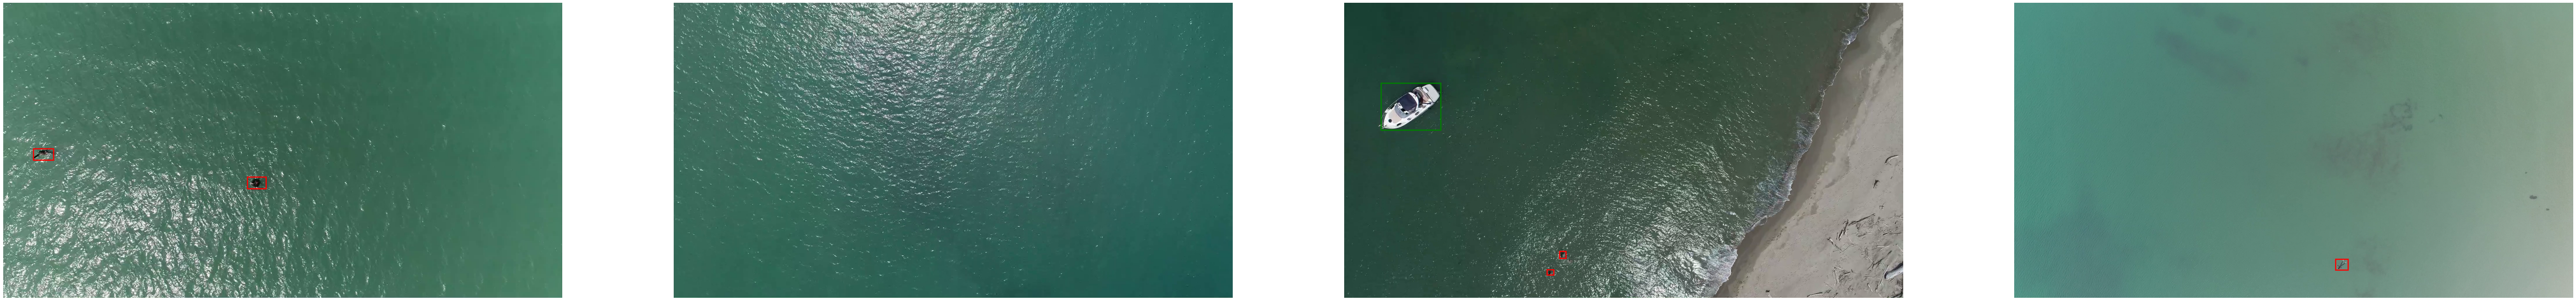

In [2]:
num_sample = 4
bb_width = 4

coco_classes = [
    {'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'animal', 'id': 18, 'name': 'dog'}, {'supercategory': 'animal', 'id': 19, 'name': 'horse'}, {'supercategory': 'animal', 'id': 20, 'name': 'sheep'}, {'supercategory': 'animal', 'id': 21, 'name': 'cow'}, {'supercategory': 'animal', 'id': 22, 'name': 'elephant'}, {'supercategory': 'animal', 'id': 23, 'name': 'bear'}, {'supercategory': 'animal', 'id': 24, 'name': 'zebra'}, {'supercategory': 'animal', 'id': 25, 'name': 'giraffe'}, {'supercategory': 'accessory', 'id': 27, 'name': 'backpack'}, {'supercategory': 'accessory', 'id': 28, 'name': 'umbrella'}, {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'}, {'supercategory': 'accessory', 'id': 32, 'name': 'tie'}, {'supercategory': 'accessory', 'id': 33, 'name': 'suitcase'}, {'supercategory': 'sports', 'id': 34, 'name': 'frisbee'}, {'supercategory': 'sports', 'id': 35, 'name': 'skis'}, {'supercategory': 'sports', 'id': 36, 'name': 'snowboard'}, {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'}, {'supercategory': 'sports', 'id': 38, 'name': 'kite'}, {'supercategory': 'sports', 'id': 39, 'name': 'baseball bat'}, {'supercategory': 'sports', 'id': 40, 'name': 'baseball glove'}, {'supercategory': 'sports', 'id': 41, 'name': 'skateboard'}, {'supercategory': 'sports', 'id': 42, 'name': 'surfboard'}, {'supercategory': 'sports', 'id': 43, 'name': 'tennis racket'}, {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'}, {'supercategory': 'kitchen', 'id': 46, 'name': 'wine glass'}, {'supercategory': 'kitchen', 'id': 47, 'name': 'cup'}, {'supercategory': 'kitchen', 'id': 48, 'name': 'fork'}, {'supercategory': 'kitchen', 'id': 49, 'name': 'knife'}, {'supercategory': 'kitchen', 'id': 50, 'name': 'spoon'}, {'supercategory': 'kitchen', 'id': 51, 'name': 'bowl'}, {'supercategory': 'food', 'id': 52, 'name': 'banana'}, {'supercategory': 'food', 'id': 53, 'name': 'apple'}, {'supercategory': 'food', 'id': 54, 'name': 'sandwich'}, {'supercategory': 'food', 'id': 55, 'name': 'orange'}, {'supercategory': 'food', 'id': 56, 'name': 'broccoli'}, {'supercategory': 'food', 'id': 57, 'name': 'carrot'}, {'supercategory': 'food', 'id': 58, 'name': 'hot dog'}, {'supercategory': 'food', 'id': 59, 'name': 'pizza'}, {'supercategory': 'food', 'id': 60, 'name': 'donut'}, {'supercategory': 'food', 'id': 61, 'name': 'cake'}, {'supercategory': 'furniture', 'id': 62, 'name': 'chair'}, {'supercategory': 'furniture', 'id': 63, 'name': 'couch'}, {'supercategory': 'furniture', 'id': 64, 'name': 'potted plant'}, {'supercategory': 'furniture', 'id': 65, 'name': 'bed'}, {'supercategory': 'furniture', 'id': 67, 'name': 'dining table'}, {'supercategory': 'furniture', 'id': 70, 'name': 'toilet'}, {'supercategory': 'electronic', 'id': 72, 'name': 'tv'}, {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'}, {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'}, {'supercategory': 'electronic', 'id': 75, 'name': 'remote'}, {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'}, {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'}, {'supercategory': 'appliance', 'id': 78, 'name': 'microwave'}, {'supercategory': 'appliance', 'id': 79, 'name': 'oven'}, {'supercategory': 'appliance', 'id': 80, 'name': 'toaster'}, {'supercategory': 'appliance', 'id': 81, 'name': 'sink'}, {'supercategory': 'appliance', 'id': 82, 'name': 'refrigerator'}, {'supercategory': 'indoor', 'id': 84, 'name': 'book'}, {'supercategory': 'indoor', 'id': 85, 'name': 'clock'}, {'supercategory': 'indoor', 'id': 86, 'name': 'vase'}, {'supercategory': 'indoor', 'id': 87, 'name': 'scissors'}, {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'}, {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'}, {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}
]

class_colours = {
    'person' : "red",
    'boat': "green",
    'surfboard': "blue",
    'wood': "cyan",
    'life_buoy': "yellow",
}

src_images = DATA_ROOT / 'images'
annotations = DATA_ROOT / 'annotations' / 'annotations_5_custom_classes.json'
#annotations = DATA_ROOT / 'annotations' / 'annotations_coco_classes.json'

cocoGt = COCO(annotations)

imgIds = sorted(cocoGt.getImgIds())
random.shuffle(imgIds)
imgIds = imgIds[:num_sample]

catIds = cocoGt.getCatIds()
cat_names = [cocoGt.loadCats(ids=cat_id)[0]['name'] for cat_id in catIds]

img_names = [cocoGt.loadImgs(ids=img_id)[0]['file_name'] for img_id in imgIds]
print("Selected Images: {}".format(img_names))
    
image_to_show = []
for i, img_name in enumerate(img_names):
    image_path = src_images / img_name
    rgb_image = Image.open(image_path)
    draw = ImageDraw.Draw(rgb_image)
    
    image_annIds = cocoGt.getAnnIds(imgIds=imgIds[i])
    image_annotations = cocoGt.loadAnns(ids=image_annIds)
            
    for image_annotation in image_annotations:
        bbox = image_annotation['bbox']
        category_id = image_annotation['category_id']
        #for coco_cat in coco_classes:
        #    if category_id == coco_cat['id']:
        #       cat_name = coco_cat['name']
        cat_name = cat_names[category_id-1]
        draw.rectangle(((bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3])), width=bb_width, outline=class_colours[cat_name])
        

    image_to_show.append(np.asarray(rgb_image))
    
fig, axes = plt.subplots(1, num_sample, figsize=(100, 100))
axes = axes.flatten()
for i in range(len(image_to_show)):
    axes[i].imshow(image_to_show[i])

for ax in axes:
    ax.set_axis_off()
            
#plt.show()

for i in range(num_sample):
    plt.imsave("trash/sample_{}.png".format(i), image_to_show[i])  
            
    
    


It draws bb annotations of a single selected image

loading annotations into memory...
Done (t=1.65s)
creating index...
index created!


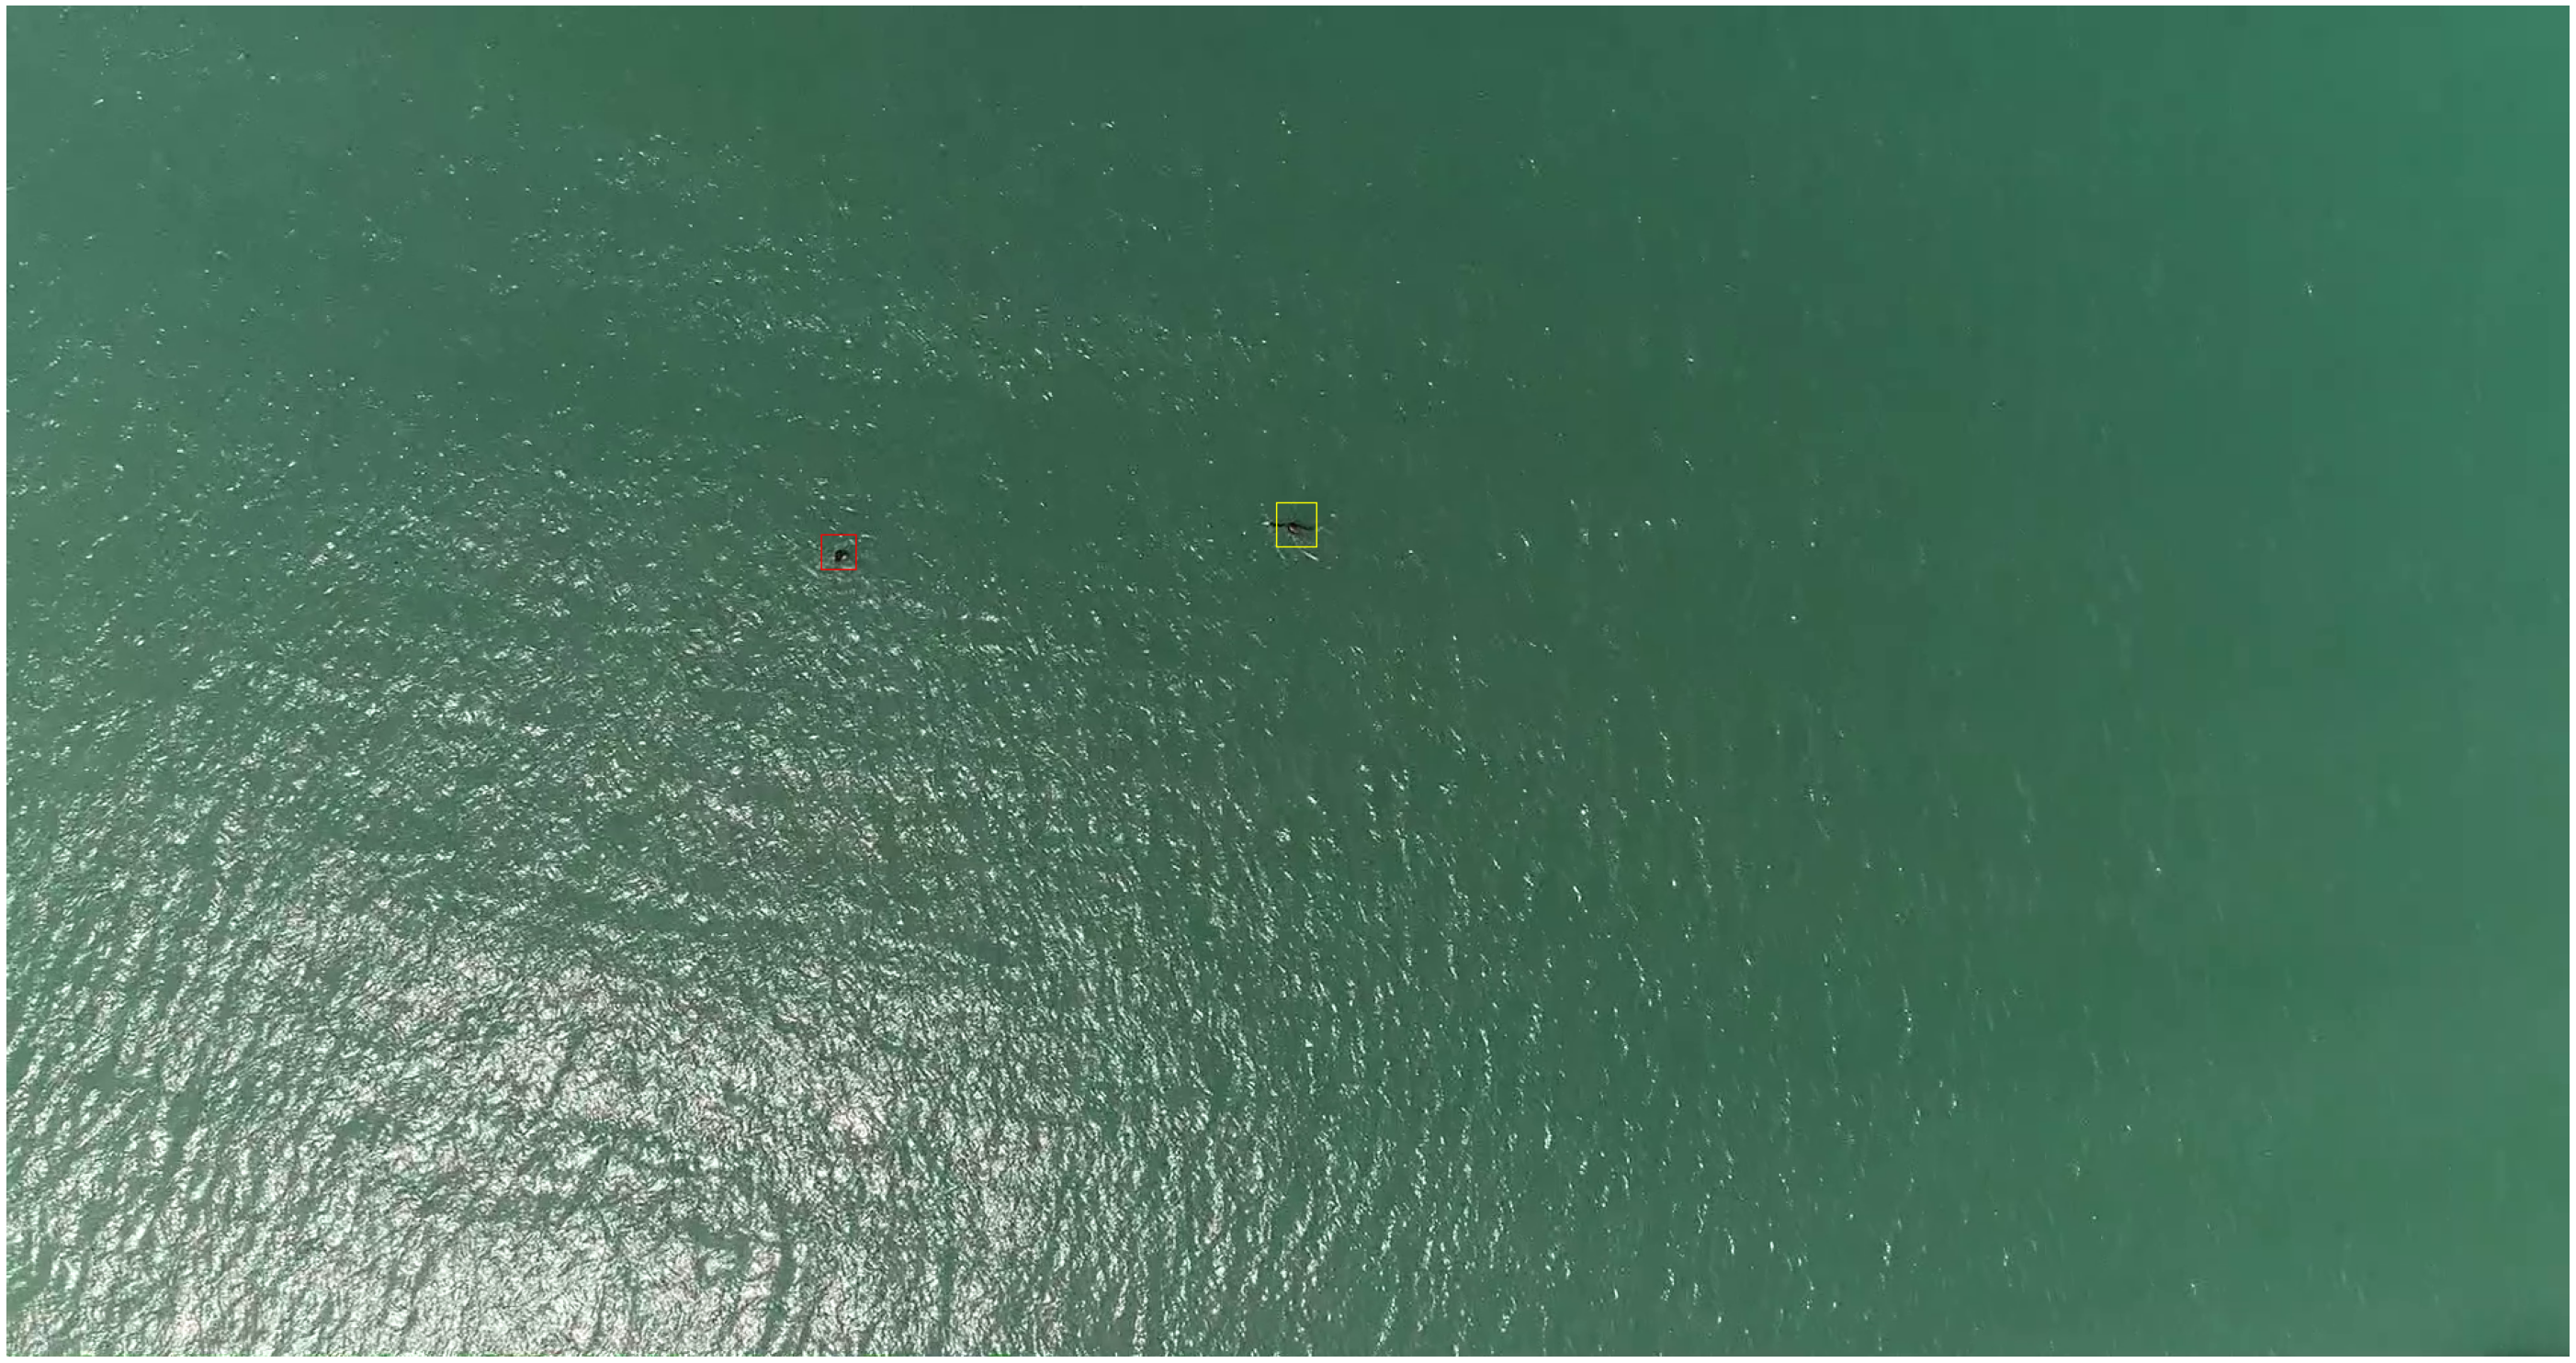

In [3]:
IMG_NAME = "DJI_0804_0007_50m_000395.PNG"

bb_width = 1

coco_classes = [
    {'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'animal', 'id': 18, 'name': 'dog'}, {'supercategory': 'animal', 'id': 19, 'name': 'horse'}, {'supercategory': 'animal', 'id': 20, 'name': 'sheep'}, {'supercategory': 'animal', 'id': 21, 'name': 'cow'}, {'supercategory': 'animal', 'id': 22, 'name': 'elephant'}, {'supercategory': 'animal', 'id': 23, 'name': 'bear'}, {'supercategory': 'animal', 'id': 24, 'name': 'zebra'}, {'supercategory': 'animal', 'id': 25, 'name': 'giraffe'}, {'supercategory': 'accessory', 'id': 27, 'name': 'backpack'}, {'supercategory': 'accessory', 'id': 28, 'name': 'umbrella'}, {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'}, {'supercategory': 'accessory', 'id': 32, 'name': 'tie'}, {'supercategory': 'accessory', 'id': 33, 'name': 'suitcase'}, {'supercategory': 'sports', 'id': 34, 'name': 'frisbee'}, {'supercategory': 'sports', 'id': 35, 'name': 'skis'}, {'supercategory': 'sports', 'id': 36, 'name': 'snowboard'}, {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'}, {'supercategory': 'sports', 'id': 38, 'name': 'kite'}, {'supercategory': 'sports', 'id': 39, 'name': 'baseball bat'}, {'supercategory': 'sports', 'id': 40, 'name': 'baseball glove'}, {'supercategory': 'sports', 'id': 41, 'name': 'skateboard'}, {'supercategory': 'sports', 'id': 42, 'name': 'surfboard'}, {'supercategory': 'sports', 'id': 43, 'name': 'tennis racket'}, {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'}, {'supercategory': 'kitchen', 'id': 46, 'name': 'wine glass'}, {'supercategory': 'kitchen', 'id': 47, 'name': 'cup'}, {'supercategory': 'kitchen', 'id': 48, 'name': 'fork'}, {'supercategory': 'kitchen', 'id': 49, 'name': 'knife'}, {'supercategory': 'kitchen', 'id': 50, 'name': 'spoon'}, {'supercategory': 'kitchen', 'id': 51, 'name': 'bowl'}, {'supercategory': 'food', 'id': 52, 'name': 'banana'}, {'supercategory': 'food', 'id': 53, 'name': 'apple'}, {'supercategory': 'food', 'id': 54, 'name': 'sandwich'}, {'supercategory': 'food', 'id': 55, 'name': 'orange'}, {'supercategory': 'food', 'id': 56, 'name': 'broccoli'}, {'supercategory': 'food', 'id': 57, 'name': 'carrot'}, {'supercategory': 'food', 'id': 58, 'name': 'hot dog'}, {'supercategory': 'food', 'id': 59, 'name': 'pizza'}, {'supercategory': 'food', 'id': 60, 'name': 'donut'}, {'supercategory': 'food', 'id': 61, 'name': 'cake'}, {'supercategory': 'furniture', 'id': 62, 'name': 'chair'}, {'supercategory': 'furniture', 'id': 63, 'name': 'couch'}, {'supercategory': 'furniture', 'id': 64, 'name': 'potted plant'}, {'supercategory': 'furniture', 'id': 65, 'name': 'bed'}, {'supercategory': 'furniture', 'id': 67, 'name': 'dining table'}, {'supercategory': 'furniture', 'id': 70, 'name': 'toilet'}, {'supercategory': 'electronic', 'id': 72, 'name': 'tv'}, {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'}, {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'}, {'supercategory': 'electronic', 'id': 75, 'name': 'remote'}, {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'}, {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'}, {'supercategory': 'appliance', 'id': 78, 'name': 'microwave'}, {'supercategory': 'appliance', 'id': 79, 'name': 'oven'}, {'supercategory': 'appliance', 'id': 80, 'name': 'toaster'}, {'supercategory': 'appliance', 'id': 81, 'name': 'sink'}, {'supercategory': 'appliance', 'id': 82, 'name': 'refrigerator'}, {'supercategory': 'indoor', 'id': 84, 'name': 'book'}, {'supercategory': 'indoor', 'id': 85, 'name': 'clock'}, {'supercategory': 'indoor', 'id': 86, 'name': 'vase'}, {'supercategory': 'indoor', 'id': 87, 'name': 'scissors'}, {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'}, {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'}, {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}
]

class_colours = {
    'person' : "red",
    'boat': "green",
    'surfboard': "blue",
    'wood': "cyan",
    'lefe_buoy': "magenta",
}

src_images = DATA_ROOT / 'images'
annotations = DATA_ROOT / 'annotations' / 'annotations_coco_classes.json'

cocoGt = COCO(annotations)
imgIds = sorted(cocoGt.getImgIds())

for imgId in imgIds:
    image = cocoGt.loadImgs(imgId)
    if image[0]['file_name'] == IMG_NAME:
        selected_imgId = imgId
        break

catIds = cocoGt.getCatIds()
cat_names = [cocoGt.loadCats(ids=cat_id)[0]['name'] for cat_id in catIds]

image_path = src_images / IMG_NAME
rgb_image = Image.open(image_path)
draw = ImageDraw.Draw(rgb_image)

image_annIds = cocoGt.getAnnIds(imgIds=selected_imgId)
image_annotations = cocoGt.loadAnns(ids=image_annIds)

first = 0
for image_annotation in image_annotations:
    bbox = image_annotation['bbox']
    category_id = image_annotation['category_id']
    for coco_cat in coco_classes:
        if category_id == coco_cat['id']:
            cat_name = coco_cat['name']
    if first == 1:
        draw.rectangle(((bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3])), width=bb_width, outline="yellow")
    else:
        draw.rectangle(((bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3])), width=bb_width, outline=class_colours[cat_name])
    first = 1
    
fig, axes = plt.subplots(figsize=(50, 50))
axes.imshow(np.asarray(rgb_image))
axes.set_axis_off()
            
plt.show()

plt.imsave("trash/sample_for_paper_{}.png".format(IMG_NAME.rsplit(".", 1)[0]), np.asarray(rgb_image))  